# Local Setup Instructions

## Prerequisites Checklist

Before running this notebook, ensure you have completed the following setup:

- [ ] **Conda environment `fraud-shield` created and activated**
  - Create: `conda env create -f environment.yml`
  - Activate: `conda activate fraud-shield`
- [ ] **Data directories created**
  - `data/processed/` - for preprocessed data
  - `models/` - for saved models
  - `results/` - for model results
- [ ] **Preprocessed data available**
  - Run `02-local-preprocessing.ipynb` first

## Environment Activation

```bash
conda activate fraud-shield
```

**Note:** This is a local execution version configured for the `fraud-shield` conda environment.

# Deep Learning Models for Fraud Detection

**Notebook:** 05-local-deep-learning.ipynb
**Objective:** Develop deep learning models using the expanded 30-feature leak-free dataset, handling class imbalance via loss functions rather than oversampling.

## Key Design Choices

1. **Focal Loss**: Down-weights well-classified examples, focusing on hard negatives
2. **Class-Weighted Loss**: Balances fraud vs legitimate without synthetic samples
3. **Threshold Tuning**: Optimal threshold found on validation, applied to test

## Architectures

- **FraudMLP**: Multi-layer perceptron with dropout and batch normalization
- **FraudResNet**: Residual MLP with skip connections
- **FraudLSTM**: LSTM treating features as a sequence (tabular-to-sequential)

In [1]:
# ============================================================
# GLOBAL IMPORTS & DEPENDENCIES
# ============================================================

import os
import sys
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Data Processing
import pandas as pd
import numpy as np

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

# Sklearn metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import pickle
import joblib
from datetime import datetime
from tqdm.auto import tqdm

print("All dependencies loaded successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All dependencies loaded successfully
PyTorch version: 2.11.0.dev20260206+cu128
CUDA available: True


In [2]:
# ============================================================
# CONFIGURATION & PATHS
# ============================================================

NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name == "local_notebooks":
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

os.chdir(PROJECT_ROOT)

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

PREPROCESSED_TRAIN_PATH = PROCESSED_DATA_DIR / 'train_preprocessed.parquet'
PREPROCESSED_VAL_PATH = PROCESSED_DATA_DIR / 'val_preprocessed.parquet'
PREPROCESSED_TEST_PATH = PROCESSED_DATA_DIR / 'test_preprocessed.parquet'
FEATURE_NAMES_PATH = MODELS_DIR / 'feature_names.pkl'

# ============================================================
# DEVICE CONFIGURATION
# ============================================================
# Set USE_CUDA = True to use GPU, False to force CPU
USE_CUDA = True  # User flag: change to False to force CPU

if USE_CUDA and torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Compute capability: {torch.cuda.get_device_capability(0)}")
else:
    DEVICE = torch.device("cpu")
    if USE_CUDA:
        print("CUDA requested but not available, using CPU")
    else:
        print("Using CPU (user preference)")

print(f"\nProject root: {PROJECT_ROOT}")
print(f"Device: {DEVICE}")

Using GPU: NVIDIA GeForce RTX 5070 Ti
CUDA version: 12.8
Compute capability: (12, 0)

Project root: /home/alireza/Desktop/projects/fraud-shield-ai
Device: cuda


## 1. Load and Prepare Data

In [3]:
# ============================================================
# DATA LOADING
# ============================================================

def load_preprocessed_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load preprocessed train, validation, and test datasets."""
    if not PREPROCESSED_TRAIN_PATH.exists():
        raise FileNotFoundError(
            f"Preprocessed data not found: {PREPROCESSED_TRAIN_PATH}\n"
            "Please run the preprocessing notebook (02-local-preprocessing.ipynb) first."
        )
    
    print("Loading preprocessed data...")
    train_df = pd.read_parquet(PREPROCESSED_TRAIN_PATH)
    val_df = pd.read_parquet(PREPROCESSED_VAL_PATH)
    test_df = pd.read_parquet(PREPROCESSED_TEST_PATH)
    
    # Rename columns if feature names file exists
    if FEATURE_NAMES_PATH.exists():
        with open(FEATURE_NAMES_PATH, 'rb') as f:
            feature_names = pickle.load(f)
        feature_cols = [col for col in train_df.columns if col != 'is_fraud']
        n = min(len(feature_cols), len(feature_names))
        rename_map = {str(i): feature_names[i] for i in range(n)}
        for df in (train_df, val_df, test_df):
            df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)
    
    print(f"Train: {train_df.shape[0]:,} samples, Fraud rate: {train_df['is_fraud'].mean():.4%}")
    print(f"Val: {val_df.shape[0]:,} samples, Fraud rate: {val_df['is_fraud'].mean():.4%}")
    print(f"Test: {test_df.shape[0]:,} samples, Fraud rate: {test_df['is_fraud'].mean():.4%}")
    
    return train_df, val_df, test_df

train_df, val_df, test_df = load_preprocessed_data()
feature_cols = [col for col in train_df.columns if col != 'is_fraud']
print(f"\nFeatures ({len(feature_cols)}): {feature_cols}")

Loading preprocessed data...
Train: 1,034,987 samples, Fraud rate: 0.5757%
Val: 122,480 samples, Fraud rate: 0.5250%
Test: 555,719 samples, Fraud rate: 0.3860%

Features (37): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month', 'is_peak_fraud_day', 'is_peak_fraud_season', 'is_high_risk_category', 'card_age_days', 'transaction_count', 'evening_high_amount', 'evening_online_shopping', 'large_city_evening', 'new_card_evening', 'high_amount_online', 'temporal_risk_score', 'geographic_risk_score', 'card_risk_score', 'risk_tier', 'amt', 'city_pop', 'customer_merchant_distance_km', 'txn_count_last_1h', 'txn_count_last_24h', 'amt_relative_to_avg', 'time_since_last_txn_seconds', 'amt_deviation_from_median', 'amt_rolling_std', 'is_new_merchant', 'category_nunique_last_24h', 'geo_velocity_kmh', 'amt_to_personal_max']


In [4]:
# ============================================================
# PREPARE TENSORS
# ============================================================

def prepare_tensors(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    feature_cols: List[str]
) -> Tuple[torch.Tensor, ...]:
    """Prepare PyTorch tensors from DataFrames with additional scaling."""
    
    # Extract arrays
    X_train = train_df[feature_cols].values.astype(np.float32)
    y_train = train_df['is_fraud'].values.astype(np.float32)
    X_val = val_df[feature_cols].values.astype(np.float32)
    y_val = val_df['is_fraud'].values.astype(np.float32)
    X_test = test_df[feature_cols].values.astype(np.float32)
    y_test = test_df['is_fraud'].values.astype(np.float32)
    
    # Additional scaling to ensure zero mean, unit variance
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Convert to tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32)
    
    return X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t, scaler

X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t, scaler = prepare_tensors(
    train_df, val_df, test_df, feature_cols
)

print(f"Training samples: {len(X_train_t):,}")
print(f"Validation samples: {len(X_val_t):,}")
print(f"Test samples: {len(X_test_t):,}")
print(f"Input dimension: {X_train_t.shape[1]}")

Training samples: 1,034,987
Validation samples: 122,480
Test samples: 555,719
Input dimension: 37


## 2. Loss Functions for Class Imbalance

In [5]:
# ============================================================
# FOCAL LOSS IMPLEMENTATION
# ============================================================

class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance.
    
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    
    Args:
        alpha: Weighting factor for positive class (fraud)
        gamma: Focusing parameter (higher = more focus on hard examples)
    """
    
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        p = torch.sigmoid(inputs)
        p_t = p * targets + (1 - p) * (1 - targets)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        loss = -alpha_t * focal_weight * torch.log(p_t + 1e-8)
        return loss.mean()


class WeightedBCELoss(nn.Module):
    """BCE Loss with class weights computed from data."""
    
    def __init__(self, pos_weight: float):
        super().__init__()
        self.pos_weight = torch.tensor([pos_weight])
    
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        pos_weight = self.pos_weight.to(inputs.device)
        return F.binary_cross_entropy_with_logits(
            inputs, targets, pos_weight=pos_weight
        )


# Compute class weight from validation set (more representative of real distribution)
val_fraud_rate = y_val_t.mean().item()
pos_weight = (1 - val_fraud_rate) / val_fraud_rate
print(f"Validation fraud rate: {val_fraud_rate:.4%}")
print(f"Computed pos_weight: {pos_weight:.2f}")

Validation fraud rate: 0.5250%
Computed pos_weight: 189.48


## 3. Neural Network Architectures

In [6]:
# ============================================================
# MLP ARCHITECTURE
# ============================================================

class FraudMLP(nn.Module):
    """
    Multi-Layer Perceptron for fraud detection.
    
    Features:
    - Batch normalization for stable training
    - Dropout for regularization
    - Learnable activation functions (PReLU)
    """
    
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int] = [128, 64, 32],
        dropout: float = 0.3
    ):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.PReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze(-1)


class ResidualBlock(nn.Module):
    """Residual block with skip connection."""
    
    def __init__(self, dim: int, dropout: float = 0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.activation = nn.PReLU()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(x + self.block(x))


class FraudResNet(nn.Module):
    """
    Residual MLP for fraud detection.
    Skip connections help with gradient flow in deeper networks.
    """
    
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 128,
        n_blocks: int = 3,
        dropout: float = 0.3
    ):
        super().__init__()
        
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU()
        )
        
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, dropout) for _ in range(n_blocks)
        ])
        
        self.output = nn.Linear(hidden_dim, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_proj(x)
        x = self.blocks(x)
        return self.output(x).squeeze(-1)


# Instantiate models
input_dim = X_train_t.shape[1]
print(f"Input dimension: {input_dim}")

Input dimension: 37


## 4. Training Infrastructure

In [7]:
# ============================================================
# TRAINING AND EVALUATION FUNCTIONS
# ============================================================

def find_best_threshold(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray
) -> Tuple[float, float]:
    """Find threshold that maximizes F1 score."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    thresholds = np.append(thresholds, 1.0)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    idx = np.nanargmax(f1_scores)
    return float(thresholds[idx]), float(f1_scores[idx])


def evaluate_predictions(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
    threshold: float = 0.5,
    dataset_name: str = "Dataset"
) -> Dict[str, float]:
    """Evaluate model predictions at given threshold."""
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    metrics = {
        'f1_score': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'pr_auc': average_precision_score(y_true, y_pred_proba)
    }
    
    print(f"\n{dataset_name} Performance (threshold={threshold:.4f}):")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"  PR-AUC: {metrics['pr_auc']:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    print(f"  Confusion: TN={tn:,} FP={fp:,} FN={fn:,} TP={tp:,}")
    print(f"  False Positive Rate: {fpr:.4%}")
    
    return metrics


class EarlyStopping:
    """Early stopping to prevent overfitting."""
    
    def __init__(self, patience: int = 10, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
    
    def __call__(self, score: float, model: nn.Module) -> bool:
        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict().copy()
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict().copy()
            self.counter = 0
        return self.early_stop

print("Training infrastructure defined.")

Training infrastructure defined.


In [8]:
# ============================================================
# MAIN TRAINING FUNCTION
# ============================================================

def train_model(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    loss_fn: nn.Module,
    n_epochs: int = 100,
    batch_size: int = 2048,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    patience: int = 15,
    use_class_balanced_sampling: bool = False
) -> Tuple[nn.Module, Dict[str, List[float]]]:
    """
    Train model with early stopping based on validation PR-AUC.
    
    Returns:
        Trained model and training history
    """
    model = model.to(DEVICE)
    loss_fn = loss_fn.to(DEVICE) if hasattr(loss_fn, 'to') else loss_fn
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    
    if use_class_balanced_sampling:
        # Oversample minority class during training
        class_counts = torch.bincount(y_train.long())
        weights = 1.0 / class_counts[y_train.long()]
        sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size * 2, shuffle=False)
    
    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    
    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'val_loss': [], 'val_pr_auc': [], 'val_f1': []}
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_losses.append(loss.item())
        
        # Validation phase
        model.eval()
        val_losses = []
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                
                val_losses.append(loss.item())
                val_preds.append(torch.sigmoid(outputs).cpu().numpy())
                val_targets.append(y_batch.cpu().numpy())
        
        # Compute metrics
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        
        val_pr_auc = average_precision_score(val_targets, val_preds)
        best_thresh, val_f1 = find_best_threshold(val_targets, val_preds)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_pr_auc'].append(val_pr_auc)
        history['val_f1'].append(val_f1)
        
        scheduler.step(val_pr_auc)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Val PR-AUC: {val_pr_auc:.4f} | Val F1: {val_f1:.4f}")
        
        # Early stopping on PR-AUC (threshold-invariant metric)
        if early_stopping(val_pr_auc, model):
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Restore best model
    if early_stopping.best_state is not None:
        model.load_state_dict(early_stopping.best_state)
    
    return model, history

print("Training function defined.")

Training function defined.


## 5. Train MLP with Focal Loss

In [9]:
# ============================================================
# TRAIN MLP WITH FOCAL LOSS
# ============================================================

print("="*80)
print("Training FraudMLP with Focal Loss")
print("="*80)

# Higher alpha gives more weight to positive class (fraud)
mlp_focal = FraudMLP(
    input_dim=input_dim,
    hidden_dims=[256, 128, 64],
    dropout=0.4
)

focal_loss = FocalLoss(alpha=0.75, gamma=2.0)

mlp_focal, mlp_focal_history = train_model(
    model=mlp_focal,
    X_train=X_train_t,
    y_train=y_train_t,
    X_val=X_val_t,
    y_val=y_val_t,
    loss_fn=focal_loss,
    n_epochs=100,
    batch_size=2048,
    lr=1e-3,
    patience=20
)

Training FraudMLP with Focal Loss


Epoch   1 | Train Loss: 0.0048 | Val Loss: 0.0018 | Val PR-AUC: 0.6213 | Val F1: 0.5779


Epoch  10 | Train Loss: 0.0016 | Val Loss: 0.0012 | Val PR-AUC: 0.8006 | Val F1: 0.7447


Epoch  20 | Train Loss: 0.0012 | Val Loss: 0.0009 | Val PR-AUC: 0.8685 | Val F1: 0.7959


Epoch  30 | Train Loss: 0.0010 | Val Loss: 0.0008 | Val PR-AUC: 0.8974 | Val F1: 0.8393


Epoch  40 | Train Loss: 0.0009 | Val Loss: 0.0011 | Val PR-AUC: 0.8680 | Val F1: 0.8106


Epoch  50 | Train Loss: 0.0008 | Val Loss: 0.0010 | Val PR-AUC: 0.8833 | Val F1: 0.8297


Epoch  60 | Train Loss: 0.0008 | Val Loss: 0.0007 | Val PR-AUC: 0.9174 | Val F1: 0.8535


Epoch  70 | Train Loss: 0.0007 | Val Loss: 0.0007 | Val PR-AUC: 0.9242 | Val F1: 0.8646


Epoch  80 | Train Loss: 0.0006 | Val Loss: 0.0010 | Val PR-AUC: 0.8833 | Val F1: 0.8302


Epoch  90 | Train Loss: 0.0006 | Val Loss: 0.0007 | Val PR-AUC: 0.9244 | Val F1: 0.8694


Epoch 100 | Train Loss: 0.0006 | Val Loss: 0.0009 | Val PR-AUC: 0.9002 | Val F1: 0.8435


In [10]:
# ============================================================
# EVALUATE MLP FOCAL ON ALL SETS
# ============================================================

def get_predictions(model: nn.Module, X: torch.Tensor) -> np.ndarray:
    """Get probability predictions from model."""
    model.eval()
    with torch.no_grad():
        X = X.to(DEVICE)
        logits = model(X)
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs

# Get predictions
y_train_pred_focal = get_predictions(mlp_focal, X_train_t)
y_val_pred_focal = get_predictions(mlp_focal, X_val_t)
y_test_pred_focal = get_predictions(mlp_focal, X_test_t)

# Find optimal threshold on validation
best_threshold_focal, best_val_f1_focal = find_best_threshold(
    y_val_t.numpy(), y_val_pred_focal
)
print(f"\nOptimal threshold (max val F1): {best_threshold_focal:.4f}")

# Evaluate at optimal threshold
print("\n" + "="*80)
print("MLP Focal Loss - Evaluation at Optimal Threshold")
print("="*80)

train_metrics_focal = evaluate_predictions(
    y_train_t.numpy(), y_train_pred_focal, best_threshold_focal, "Train"
)
val_metrics_focal = evaluate_predictions(
    y_val_t.numpy(), y_val_pred_focal, best_threshold_focal, "Validation"
)
test_metrics_focal = evaluate_predictions(
    y_test_t.numpy(), y_test_pred_focal, best_threshold_focal, "Test"
)


Optimal threshold (max val F1): 0.5535

MLP Focal Loss - Evaluation at Optimal Threshold



Train Performance (threshold=0.5535):
  F1-Score: 0.8766
  Precision: 0.9222
  Recall: 0.8353
  ROC-AUC: 0.9992
  PR-AUC: 0.9428


  Confusion: TN=1,028,609 FP=420 FN=981 TP=4,977
  False Positive Rate: 0.0408%

Validation Performance (threshold=0.5535):
  F1-Score: 0.8435
  Precision: 0.8814
  Recall: 0.8087
  ROC-AUC: 0.9969
  PR-AUC: 0.9002
  Confusion: TN=121,767 FP=70 FN=123 TP=520
  False Positive Rate: 0.0575%



Test Performance (threshold=0.5535):
  F1-Score: 0.5735
  Precision: 0.5146
  Recall: 0.6476
  ROC-AUC: 0.9780
  PR-AUC: 0.6367


  Confusion: TN=552,264 FP=1,310 FN=756 TP=1,389
  False Positive Rate: 0.2366%


## 6. Train MLP with Weighted BCE

In [11]:
# ============================================================
# TRAIN MLP WITH WEIGHTED BCE LOSS
# ============================================================

print("="*80)
print("Training FraudMLP with Weighted BCE Loss")
print("="*80)

mlp_wbce = FraudMLP(
    input_dim=input_dim,
    hidden_dims=[256, 128, 64],
    dropout=0.4
)

# Use pos_weight computed from validation distribution
wbce_loss = WeightedBCELoss(pos_weight=pos_weight)

mlp_wbce, mlp_wbce_history = train_model(
    model=mlp_wbce,
    X_train=X_train_t,
    y_train=y_train_t,
    X_val=X_val_t,
    y_val=y_val_t,
    loss_fn=wbce_loss,
    n_epochs=100,
    batch_size=2048,
    lr=1e-3,
    patience=20
)

Training FraudMLP with Weighted BCE Loss


Epoch   1 | Train Loss: 0.5518 | Val Loss: 0.3362 | Val PR-AUC: 0.3099 | Val F1: 0.4352


Epoch  10 | Train Loss: 0.2693 | Val Loss: 0.1945 | Val PR-AUC: 0.7297 | Val F1: 0.6787


Epoch  20 | Train Loss: 0.1950 | Val Loss: 0.1470 | Val PR-AUC: 0.8334 | Val F1: 0.7557


Epoch  30 | Train Loss: 0.1615 | Val Loss: 0.1357 | Val PR-AUC: 0.8724 | Val F1: 0.8063


Epoch  40 | Train Loss: 0.1414 | Val Loss: 0.1424 | Val PR-AUC: 0.8866 | Val F1: 0.8224


Epoch  50 | Train Loss: 0.1307 | Val Loss: 0.1392 | Val PR-AUC: 0.8940 | Val F1: 0.8285


Epoch  60 | Train Loss: 0.1216 | Val Loss: 0.1451 | Val PR-AUC: 0.9023 | Val F1: 0.8335


Epoch  70 | Train Loss: 0.1000 | Val Loss: 0.1456 | Val PR-AUC: 0.9023 | Val F1: 0.8355


Epoch  80 | Train Loss: 0.0981 | Val Loss: 0.1571 | Val PR-AUC: 0.9081 | Val F1: 0.8502


Epoch  90 | Train Loss: 0.0970 | Val Loss: 0.1445 | Val PR-AUC: 0.9198 | Val F1: 0.8598


Epoch 100 | Train Loss: 0.0865 | Val Loss: 0.1617 | Val PR-AUC: 0.9196 | Val F1: 0.8612


In [12]:
# ============================================================
# EVALUATE MLP WEIGHTED BCE
# ============================================================

y_train_pred_wbce = get_predictions(mlp_wbce, X_train_t)
y_val_pred_wbce = get_predictions(mlp_wbce, X_val_t)
y_test_pred_wbce = get_predictions(mlp_wbce, X_test_t)

best_threshold_wbce, best_val_f1_wbce = find_best_threshold(
    y_val_t.numpy(), y_val_pred_wbce
)
print(f"\nOptimal threshold (max val F1): {best_threshold_wbce:.4f}")

print("\n" + "="*80)
print("MLP Weighted BCE - Evaluation at Optimal Threshold")
print("="*80)

train_metrics_wbce = evaluate_predictions(
    y_train_t.numpy(), y_train_pred_wbce, best_threshold_wbce, "Train"
)
val_metrics_wbce = evaluate_predictions(
    y_val_t.numpy(), y_val_pred_wbce, best_threshold_wbce, "Validation"
)
test_metrics_wbce = evaluate_predictions(
    y_test_t.numpy(), y_test_pred_wbce, best_threshold_wbce, "Test"
)


Optimal threshold (max val F1): 0.9942

MLP Weighted BCE - Evaluation at Optimal Threshold



Train Performance (threshold=0.9942):
  F1-Score: 0.8905
  Precision: 0.9032
  Recall: 0.8781
  ROC-AUC: 0.9997
  PR-AUC: 0.9589


  Confusion: TN=1,028,468 FP=561 FN=726 TP=5,232
  False Positive Rate: 0.0545%

Validation Performance (threshold=0.9942):
  F1-Score: 0.8612
  Precision: 0.8687
  Recall: 0.8538
  ROC-AUC: 0.9981
  PR-AUC: 0.9196
  Confusion: TN=121,754 FP=83 FN=94 TP=549
  False Positive Rate: 0.0681%



Test Performance (threshold=0.9942):
  F1-Score: 0.6546
  Precision: 0.5961
  Recall: 0.7259
  ROC-AUC: 0.9890
  PR-AUC: 0.7179


  Confusion: TN=552,519 FP=1,055 FN=588 TP=1,557
  False Positive Rate: 0.1906%


## 7. Train ResNet Architecture

In [13]:
# ============================================================
# TRAIN RESNET WITH FOCAL LOSS
# ============================================================

print("="*80)
print("Training FraudResNet with Focal Loss")
print("="*80)

resnet_model = FraudResNet(
    input_dim=input_dim,
    hidden_dim=128,
    n_blocks=4,
    dropout=0.3
)

focal_loss_resnet = FocalLoss(alpha=0.75, gamma=2.0)

resnet_model, resnet_history = train_model(
    model=resnet_model,
    X_train=X_train_t,
    y_train=y_train_t,
    X_val=X_val_t,
    y_val=y_val_t,
    loss_fn=focal_loss_resnet,
    n_epochs=100,
    batch_size=2048,
    lr=1e-3,
    patience=20
)

Training FraudResNet with Focal Loss


Epoch   1 | Train Loss: 0.0031 | Val Loss: 0.0015 | Val PR-AUC: 0.7557 | Val F1: 0.7077


Epoch  10 | Train Loss: 0.0009 | Val Loss: 0.0009 | Val PR-AUC: 0.8858 | Val F1: 0.8209


Epoch  20 | Train Loss: 0.0005 | Val Loss: 0.0008 | Val PR-AUC: 0.9143 | Val F1: 0.8623


Epoch  30 | Train Loss: 0.0004 | Val Loss: 0.0011 | Val PR-AUC: 0.9071 | Val F1: 0.8564


Epoch  40 | Train Loss: 0.0003 | Val Loss: 0.0019 | Val PR-AUC: 0.8804 | Val F1: 0.8371


Early stopping at epoch 45


In [14]:
# ============================================================
# EVALUATE RESNET
# ============================================================

y_train_pred_resnet = get_predictions(resnet_model, X_train_t)
y_val_pred_resnet = get_predictions(resnet_model, X_val_t)
y_test_pred_resnet = get_predictions(resnet_model, X_test_t)

best_threshold_resnet, best_val_f1_resnet = find_best_threshold(
    y_val_t.numpy(), y_val_pred_resnet
)
print(f"\nOptimal threshold (max val F1): {best_threshold_resnet:.4f}")

print("\n" + "="*80)
print("FraudResNet - Evaluation at Optimal Threshold")
print("="*80)

train_metrics_resnet = evaluate_predictions(
    y_train_t.numpy(), y_train_pred_resnet, best_threshold_resnet, "Train"
)
val_metrics_resnet = evaluate_predictions(
    y_val_t.numpy(), y_val_pred_resnet, best_threshold_resnet, "Validation"
)
test_metrics_resnet = evaluate_predictions(
    y_test_t.numpy(), y_test_pred_resnet, best_threshold_resnet, "Test"
)


Optimal threshold (max val F1): 0.5858

FraudResNet - Evaluation at Optimal Threshold



Train Performance (threshold=0.5858):
  F1-Score: 0.9500
  Precision: 0.9604
  Recall: 0.9399
  ROC-AUC: 1.0000
  PR-AUC: 0.9919


  Confusion: TN=1,028,798 FP=231 FN=358 TP=5,600
  False Positive Rate: 0.0224%

Validation Performance (threshold=0.5858):
  F1-Score: 0.8585
  Precision: 0.8885
  Recall: 0.8305
  ROC-AUC: 0.9945
  PR-AUC: 0.9032
  Confusion: TN=121,770 FP=67 FN=109 TP=534
  False Positive Rate: 0.0550%



Test Performance (threshold=0.5858):
  F1-Score: 0.5159
  Precision: 0.4085
  Recall: 0.6998
  ROC-AUC: 0.9782
  PR-AUC: 0.6300


  Confusion: TN=551,401 FP=2,173 FN=644 TP=1,501
  False Positive Rate: 0.3925%


## 8. Train LSTM Architecture

LSTM treats each feature as a timestep (standard tabular-to-sequential approach). This captures potential sequential dependencies between feature groups.

In [15]:
# ============================================================
# LSTM ARCHITECTURE
# ============================================================

class FraudLSTM(nn.Module):
    """
    LSTM for fraud detection on tabular data.
    Each feature is treated as a single timestep with input_size=1,
    so the LSTM processes the feature vector as a sequence.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_size: int = 64,
        num_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False
        )

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 32),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, features) -> (batch, features, 1) = sequence of timesteps
        x = x.unsqueeze(-1)
        lstm_out, (h_n, _) = self.lstm(x)
        # Use final hidden state from last layer
        final_hidden = h_n[-1]
        return self.classifier(final_hidden).squeeze(-1)


# Train LSTM
print("=" * 80)
print("Training FraudLSTM with Focal Loss")
print("=" * 80)

lstm_model = FraudLSTM(
    input_dim=input_dim,
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)

focal_loss_lstm = FocalLoss(alpha=0.75, gamma=2.0)

lstm_model, lstm_history = train_model(
    model=lstm_model,
    X_train=X_train_t,
    y_train=y_train_t,
    X_val=X_val_t,
    y_val=y_val_t,
    loss_fn=focal_loss_lstm,
    n_epochs=100,
    batch_size=2048,
    lr=1e-3,
    patience=20
)

Training FraudLSTM with Focal Loss


Epoch   1 | Train Loss: 0.0062 | Val Loss: 0.0029 | Val PR-AUC: 0.4135 | Val F1: 0.4278


Epoch  10 | Train Loss: 0.0020 | Val Loss: 0.0017 | Val PR-AUC: 0.7182 | Val F1: 0.6731


Epoch  20 | Train Loss: 0.0015 | Val Loss: 0.0016 | Val PR-AUC: 0.7622 | Val F1: 0.7274


Epoch  30 | Train Loss: 0.0010 | Val Loss: 0.0014 | Val PR-AUC: 0.8091 | Val F1: 0.7798


Epoch  40 | Train Loss: 0.0007 | Val Loss: 0.0015 | Val PR-AUC: 0.8291 | Val F1: 0.7918


Epoch  50 | Train Loss: 0.0006 | Val Loss: 0.0020 | Val PR-AUC: 0.8167 | Val F1: 0.7786


Epoch  60 | Train Loss: 0.0005 | Val Loss: 0.0023 | Val PR-AUC: 0.8044 | Val F1: 0.7711


Early stopping at epoch 62


In [16]:
# ============================================================
# EVALUATE LSTM
# ============================================================

def get_predictions_batched(model: nn.Module, X: torch.Tensor, batch_size: int = 4096) -> np.ndarray:
    """Batched inference to avoid CUDA OOM on large datasets."""
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size].to(DEVICE)
            logits = model(batch)
            preds.append(torch.sigmoid(logits).cpu().numpy())
    return np.concatenate(preds)

y_train_pred_lstm = get_predictions_batched(lstm_model, X_train_t)
y_val_pred_lstm = get_predictions_batched(lstm_model, X_val_t)
y_test_pred_lstm = get_predictions_batched(lstm_model, X_test_t)

best_threshold_lstm, best_val_f1_lstm = find_best_threshold(
    y_val_t.numpy(), y_val_pred_lstm
)
print(f"\nOptimal threshold (max val F1): {best_threshold_lstm:.4f}")

print("\n" + "="*80)
print("FraudLSTM - Evaluation at Optimal Threshold")
print("="*80)

train_metrics_lstm = evaluate_predictions(
    y_train_t.numpy(), y_train_pred_lstm, best_threshold_lstm, "Train"
)
val_metrics_lstm = evaluate_predictions(
    y_val_t.numpy(), y_val_pred_lstm, best_threshold_lstm, "Validation"
)
test_metrics_lstm = evaluate_predictions(
    y_test_t.numpy(), y_test_pred_lstm, best_threshold_lstm, "Test"
)


Optimal threshold (max val F1): 0.6396

FraudLSTM - Evaluation at Optimal Threshold



Train Performance (threshold=0.6396):
  F1-Score: 0.8896
  Precision: 0.9643
  Recall: 0.8256
  ROC-AUC: 0.9997
  PR-AUC: 0.9641


  Confusion: TN=1,028,847 FP=182 FN=1,039 TP=4,919
  False Positive Rate: 0.0177%

Validation Performance (threshold=0.6396):
  F1-Score: 0.7746
  Precision: 0.8794
  Recall: 0.6921
  ROC-AUC: 0.9757
  PR-AUC: 0.8077
  Confusion: TN=121,776 FP=61 FN=198 TP=445
  False Positive Rate: 0.0501%



Test Performance (threshold=0.6396):
  F1-Score: 0.4616
  Precision: 0.3549
  Recall: 0.6601
  ROC-AUC: 0.9660
  PR-AUC: 0.5130


  Confusion: TN=551,000 FP=2,574 FN=729 TP=1,416
  False Positive Rate: 0.4650%


## 9. Model Comparison and Selection

In [17]:
# ============================================================
# MODEL COMPARISON
# ============================================================

comparison_data = {
    'Model': ['MLP + Focal Loss', 'MLP + Weighted BCE', 'ResNet + Focal Loss', 'LSTM + Focal Loss'],
    'Threshold': [best_threshold_focal, best_threshold_wbce, best_threshold_resnet, best_threshold_lstm],
    'Val F1': [val_metrics_focal['f1_score'], val_metrics_wbce['f1_score'], val_metrics_resnet['f1_score'], val_metrics_lstm['f1_score']],
    'Val PR-AUC': [val_metrics_focal['pr_auc'], val_metrics_wbce['pr_auc'], val_metrics_resnet['pr_auc'], val_metrics_lstm['pr_auc']],
    'Val ROC-AUC': [val_metrics_focal['roc_auc'], val_metrics_wbce['roc_auc'], val_metrics_resnet['roc_auc'], val_metrics_lstm['roc_auc']],
    'Test F1': [test_metrics_focal['f1_score'], test_metrics_wbce['f1_score'], test_metrics_resnet['f1_score'], test_metrics_lstm['f1_score']],
    'Test PR-AUC': [test_metrics_focal['pr_auc'], test_metrics_wbce['pr_auc'], test_metrics_resnet['pr_auc'], test_metrics_lstm['pr_auc']],
    'Test ROC-AUC': [test_metrics_focal['roc_auc'], test_metrics_wbce['roc_auc'], test_metrics_resnet['roc_auc'], test_metrics_lstm['roc_auc']],
    'Test Precision': [test_metrics_focal['precision'], test_metrics_wbce['precision'], test_metrics_resnet['precision'], test_metrics_lstm['precision']],
    'Test Recall': [test_metrics_focal['recall'], test_metrics_wbce['recall'], test_metrics_resnet['recall'], test_metrics_lstm['recall']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Select best model based on test F1 (since we've already tuned threshold on val)
best_idx = comparison_df['Test F1'].idxmax()
print(f"\nBest Model: {comparison_df.loc[best_idx, 'Model']}")
print(f"  Test F1: {comparison_df.loc[best_idx, 'Test F1']:.4f}")
print(f"  Test PR-AUC: {comparison_df.loc[best_idx, 'Test PR-AUC']:.4f}")


MODEL COMPARISON SUMMARY
              Model  Threshold   Val F1  Val PR-AUC  Val ROC-AUC  Test F1  Test PR-AUC  Test ROC-AUC  Test Precision  Test Recall
   MLP + Focal Loss   0.553543 0.843471    0.900224     0.996903 0.573493     0.636701      0.978025        0.514635     0.647552
 MLP + Weighted BCE   0.994154 0.861176    0.919643     0.998058 0.654614     0.717912      0.988973        0.596095     0.725874
ResNet + Focal Loss   0.585788 0.858521    0.903178     0.994488 0.515896     0.629957      0.978237        0.408547     0.699767
  LSTM + Focal Loss   0.639600 0.774587    0.807657     0.975663 0.461614     0.512970      0.965991        0.354887     0.660140

Best Model: MLP + Weighted BCE
  Test F1: 0.6546
  Test PR-AUC: 0.7179


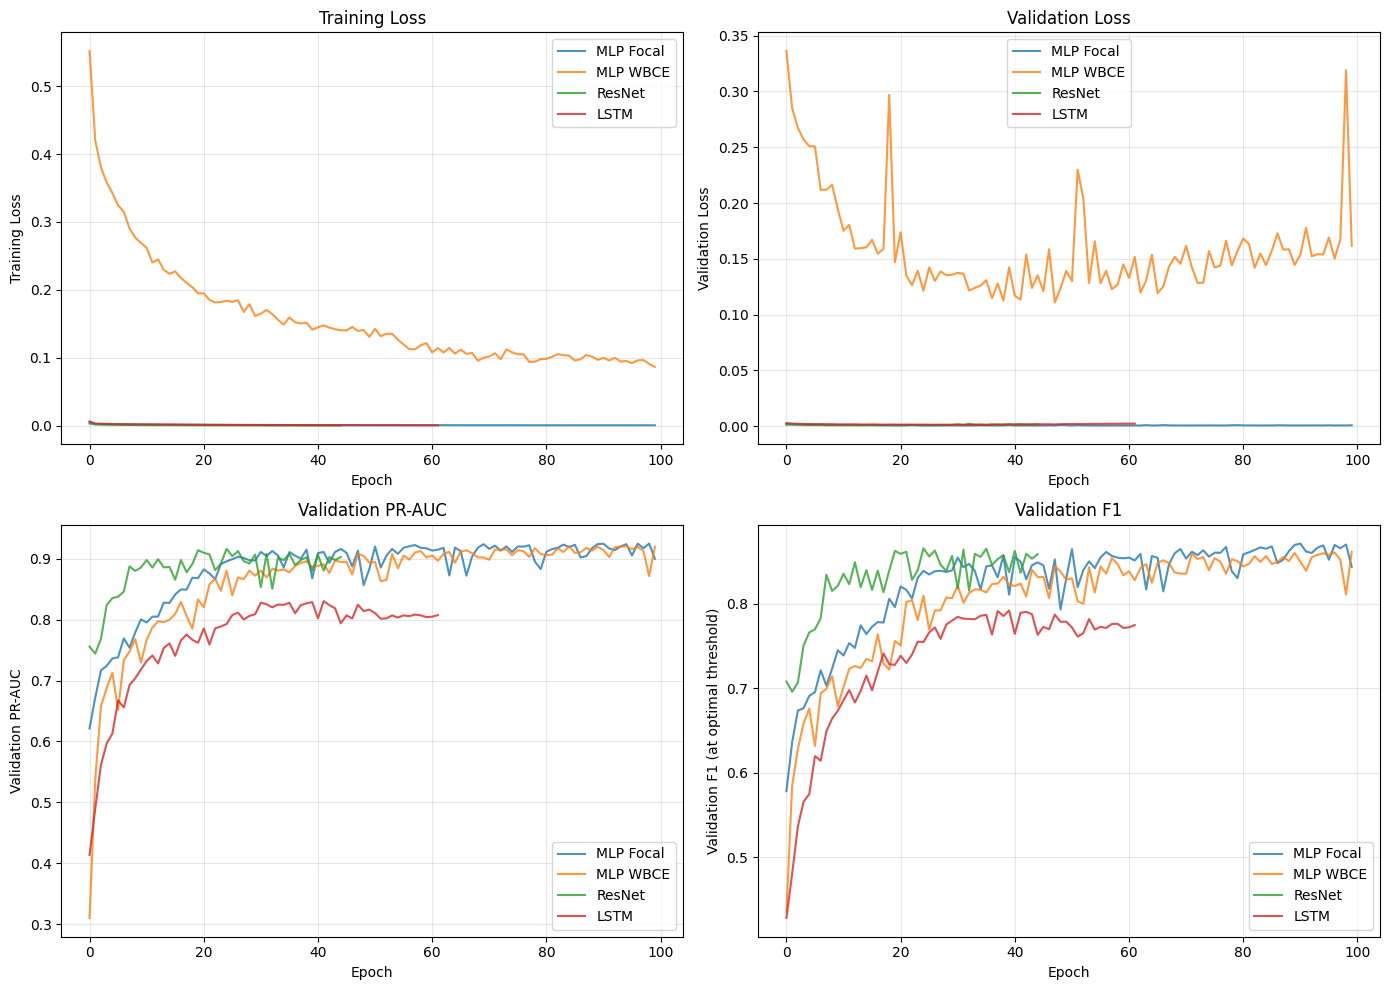

In [18]:
# ============================================================
# PLOT TRAINING CURVES
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training Loss
axes[0, 0].plot(mlp_focal_history['train_loss'], label='MLP Focal', alpha=0.8)
axes[0, 0].plot(mlp_wbce_history['train_loss'], label='MLP WBCE', alpha=0.8)
axes[0, 0].plot(resnet_history['train_loss'], label='ResNet', alpha=0.8)
axes[0, 0].plot(lstm_history['train_loss'], label='LSTM', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Training Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation Loss
axes[0, 1].plot(mlp_focal_history['val_loss'], label='MLP Focal', alpha=0.8)
axes[0, 1].plot(mlp_wbce_history['val_loss'], label='MLP WBCE', alpha=0.8)
axes[0, 1].plot(resnet_history['val_loss'], label='ResNet', alpha=0.8)
axes[0, 1].plot(lstm_history['val_loss'], label='LSTM', alpha=0.8)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Validation PR-AUC
axes[1, 0].plot(mlp_focal_history['val_pr_auc'], label='MLP Focal', alpha=0.8)
axes[1, 0].plot(mlp_wbce_history['val_pr_auc'], label='MLP WBCE', alpha=0.8)
axes[1, 0].plot(resnet_history['val_pr_auc'], label='ResNet', alpha=0.8)
axes[1, 0].plot(lstm_history['val_pr_auc'], label='LSTM', alpha=0.8)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Validation PR-AUC')
axes[1, 0].set_title('Validation PR-AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation F1
axes[1, 1].plot(mlp_focal_history['val_f1'], label='MLP Focal', alpha=0.8)
axes[1, 1].plot(mlp_wbce_history['val_f1'], label='MLP WBCE', alpha=0.8)
axes[1, 1].plot(resnet_history['val_f1'], label='ResNet', alpha=0.8)
axes[1, 1].plot(lstm_history['val_f1'], label='LSTM', alpha=0.8)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation F1 (at optimal threshold)')
axes[1, 1].set_title('Validation F1')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'deep_learning_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

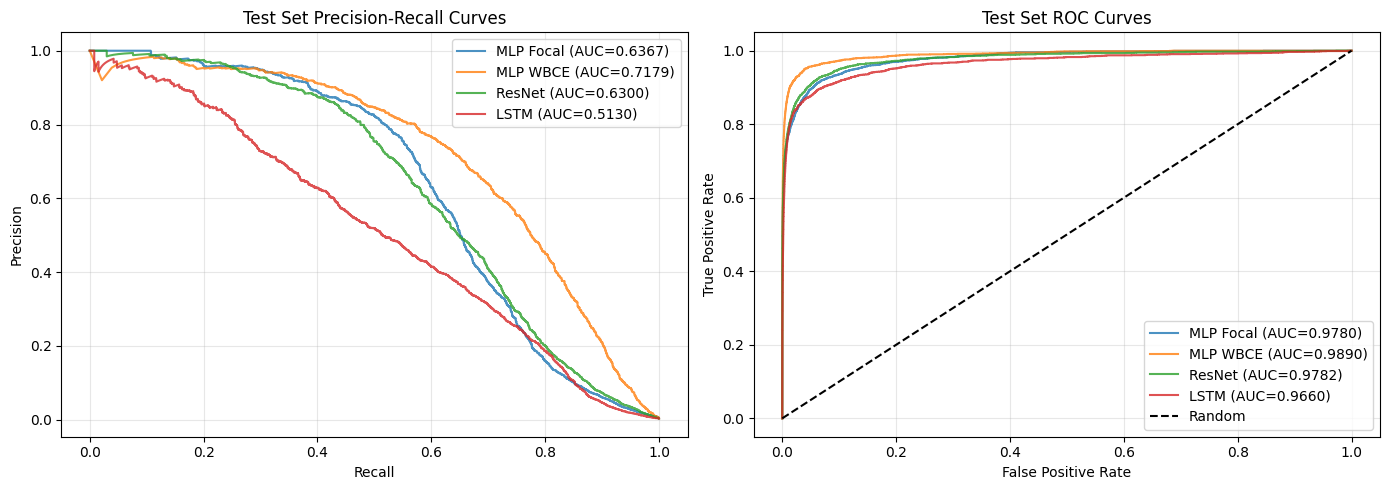

In [19]:
# ============================================================
# PLOT PR AND ROC CURVES
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PR Curves for Test Set
for name, preds in [('MLP Focal', y_test_pred_focal), ('MLP WBCE', y_test_pred_wbce), ('ResNet', y_test_pred_resnet), ('LSTM', y_test_pred_lstm)]:
    precision, recall, _ = precision_recall_curve(y_test_t.numpy(), preds)
    pr_auc = average_precision_score(y_test_t.numpy(), preds)
    axes[0].plot(recall, precision, label=f'{name} (AUC={pr_auc:.4f})', alpha=0.8)

axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Test Set Precision-Recall Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROC Curves for Test Set
for name, preds in [('MLP Focal', y_test_pred_focal), ('MLP WBCE', y_test_pred_wbce), ('ResNet', y_test_pred_resnet), ('LSTM', y_test_pred_lstm)]:
    fpr, tpr, _ = roc_curve(y_test_t.numpy(), preds)
    roc_auc = roc_auc_score(y_test_t.numpy(), preds)
    axes[1].plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.4f})', alpha=0.8)

axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Test Set ROC Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'deep_learning_pr_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Save Best Model

In [20]:
# ============================================================
# SAVE BEST MODEL
# ============================================================

# Determine best model
models_dict = {
    'MLP + Focal Loss': (mlp_focal, best_threshold_focal, test_metrics_focal),
    'MLP + Weighted BCE': (mlp_wbce, best_threshold_wbce, test_metrics_wbce),
    'ResNet + Focal Loss': (resnet_model, best_threshold_resnet, test_metrics_resnet),
    'LSTM + Focal Loss': (lstm_model, best_threshold_lstm, test_metrics_lstm)
}

best_model_name = comparison_df.loc[best_idx, 'Model']
best_model, best_threshold, best_metrics = models_dict[best_model_name]

# Save model
model_path = MODELS_DIR / 'dl_best_model.pt'
torch.save({
    'model_state_dict': best_model.state_dict(),
    'model_class': best_model.__class__.__name__,
    'input_dim': input_dim,
    'threshold': best_threshold,
    'metrics': best_metrics,
    'feature_cols': feature_cols
}, model_path)

print(f"Best model saved: {model_path}")

# Save scaler
scaler_path = MODELS_DIR / 'dl_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved: {scaler_path}")

# Save comparison results
comparison_df.to_csv(RESULTS_DIR / 'deep_learning_comparison.csv', index=False)
print(f"Comparison saved: {RESULTS_DIR / 'deep_learning_comparison.csv'}")

Best model saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/dl_best_model.pt
Scaler saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/dl_scaler.pkl
Comparison saved: /home/alireza/Desktop/projects/fraud-shield-ai/results/deep_learning_comparison.csv


## 11. Hyperparameter Tuning with Optuna

Use Optuna to tune the best-performing DL architecture (MLP + Focal Loss) by searching over hidden layer sizes, dropout, learning rate, batch size, and Focal Loss alpha/gamma.

In [21]:
# ============================================================
# OPTUNA HYPERPARAMETER TUNING FOR MLP
# ============================================================
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def dl_objective(trial: optuna.Trial) -> float:
    """Optuna objective: maximize validation PR-AUC for MLP."""
    n_layers = trial.suggest_int('n_layers', 2, 4)
    hidden_dims = []
    for i in range(n_layers):
        hidden_dims.append(trial.suggest_categorical(f'hidden_dim_{i}', [32, 64, 128, 256]))

    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [1024, 2048, 4096])
    alpha = trial.suggest_float('focal_alpha', 0.25, 0.90)
    gamma = trial.suggest_float('focal_gamma', 1.0, 3.0)

    model = FraudMLP(input_dim=input_dim, hidden_dims=hidden_dims, dropout=dropout)
    loss_fn = FocalLoss(alpha=alpha, gamma=gamma)

    model, history = train_model(
        model=model,
        X_train=X_train_t,
        y_train=y_train_t,
        X_val=X_val_t,
        y_val=y_val_t,
        loss_fn=loss_fn,
        n_epochs=50,
        batch_size=batch_size,
        lr=lr,
        patience=10
    )

    # Return best val PR-AUC from history
    return max(history['val_pr_auc'])

dl_study = optuna.create_study(direction='maximize', study_name='dl_mlp_tuning')
dl_study.optimize(dl_objective, n_trials=10, show_progress_bar=True)

print(f"\nBest trial PR-AUC: {dl_study.best_value:.4f}")
print("Best hyperparameters:")
for k, v in dl_study.best_params.items():
    print(f"  {k}: {v}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   1 | Train Loss: 0.0036 | Val Loss: 0.0016 | Val PR-AUC: 0.6956 | Val F1: 0.6477


Epoch  10 | Train Loss: 0.0011 | Val Loss: 0.0009 | Val PR-AUC: 0.8644 | Val F1: 0.8043


Epoch  20 | Train Loss: 0.0008 | Val Loss: 0.0007 | Val PR-AUC: 0.9140 | Val F1: 0.8452


Epoch  30 | Train Loss: 0.0007 | Val Loss: 0.0007 | Val PR-AUC: 0.9164 | Val F1: 0.8490


Epoch  40 | Train Loss: 0.0007 | Val Loss: 0.0008 | Val PR-AUC: 0.9095 | Val F1: 0.8451


Epoch  50 | Train Loss: 0.0006 | Val Loss: 0.0007 | Val PR-AUC: 0.9299 | Val F1: 0.8741


Epoch   1 | Train Loss: 0.0186 | Val Loss: 0.0046 | Val PR-AUC: 0.3815 | Val F1: 0.4453


Epoch  10 | Train Loss: 0.0024 | Val Loss: 0.0018 | Val PR-AUC: 0.6911 | Val F1: 0.6494


Epoch  20 | Train Loss: 0.0020 | Val Loss: 0.0015 | Val PR-AUC: 0.7313 | Val F1: 0.6910


Epoch  30 | Train Loss: 0.0018 | Val Loss: 0.0014 | Val PR-AUC: 0.7622 | Val F1: 0.7101


Epoch  40 | Train Loss: 0.0017 | Val Loss: 0.0013 | Val PR-AUC: 0.7999 | Val F1: 0.7314


Epoch  50 | Train Loss: 0.0016 | Val Loss: 0.0011 | Val PR-AUC: 0.8351 | Val F1: 0.7692


Epoch   1 | Train Loss: 0.0020 | Val Loss: 0.0010 | Val PR-AUC: 0.7433 | Val F1: 0.7094


Epoch  10 | Train Loss: 0.0006 | Val Loss: 0.0006 | Val PR-AUC: 0.8635 | Val F1: 0.8042


Epoch  20 | Train Loss: 0.0005 | Val Loss: 0.0005 | Val PR-AUC: 0.9069 | Val F1: 0.8482


Epoch  30 | Train Loss: 0.0004 | Val Loss: 0.0005 | Val PR-AUC: 0.9060 | Val F1: 0.8604


Early stopping at epoch 37


Epoch   1 | Train Loss: 0.0951 | Val Loss: 0.0410 | Val PR-AUC: 0.2869 | Val F1: 0.3874


Epoch  10 | Train Loss: 0.0038 | Val Loss: 0.0025 | Val PR-AUC: 0.2610 | Val F1: 0.4277


Early stopping at epoch 13


Epoch   1 | Train Loss: 0.0039 | Val Loss: 0.0021 | Val PR-AUC: 0.6711 | Val F1: 0.6562


Epoch  10 | Train Loss: 0.0017 | Val Loss: 0.0012 | Val PR-AUC: 0.8685 | Val F1: 0.7915


Epoch  20 | Train Loss: 0.0014 | Val Loss: 0.0010 | Val PR-AUC: 0.8888 | Val F1: 0.8180


Epoch  30 | Train Loss: 0.0012 | Val Loss: 0.0011 | Val PR-AUC: 0.8781 | Val F1: 0.8010


Epoch  40 | Train Loss: 0.0011 | Val Loss: 0.0009 | Val PR-AUC: 0.9113 | Val F1: 0.8496


Epoch  50 | Train Loss: 0.0010 | Val Loss: 0.0009 | Val PR-AUC: 0.9193 | Val F1: 0.8626


Epoch   1 | Train Loss: 0.0191 | Val Loss: 0.0046 | Val PR-AUC: 0.3618 | Val F1: 0.4408


Epoch  10 | Train Loss: 0.0021 | Val Loss: 0.0015 | Val PR-AUC: 0.6680 | Val F1: 0.6131


Epoch  20 | Train Loss: 0.0017 | Val Loss: 0.0013 | Val PR-AUC: 0.7274 | Val F1: 0.6731


Epoch  30 | Train Loss: 0.0016 | Val Loss: 0.0013 | Val PR-AUC: 0.7442 | Val F1: 0.6913


Epoch  40 | Train Loss: 0.0015 | Val Loss: 0.0013 | Val PR-AUC: 0.7597 | Val F1: 0.7054


Epoch  50 | Train Loss: 0.0014 | Val Loss: 0.0012 | Val PR-AUC: 0.7769 | Val F1: 0.7211


Epoch   1 | Train Loss: 0.0095 | Val Loss: 0.0014 | Val PR-AUC: 0.5529 | Val F1: 0.5360


Epoch  10 | Train Loss: 0.0009 | Val Loss: 0.0007 | Val PR-AUC: 0.8118 | Val F1: 0.7489


Epoch  20 | Train Loss: 0.0007 | Val Loss: 0.0005 | Val PR-AUC: 0.8898 | Val F1: 0.8255


Epoch  30 | Train Loss: 0.0005 | Val Loss: 0.0004 | Val PR-AUC: 0.9182 | Val F1: 0.8593


Epoch  40 | Train Loss: 0.0004 | Val Loss: 0.0004 | Val PR-AUC: 0.9150 | Val F1: 0.8609
Early stopping at epoch 40


Epoch   1 | Train Loss: 0.0344 | Val Loss: 0.0073 | Val PR-AUC: 0.3337 | Val F1: 0.4348


Epoch  10 | Train Loss: 0.0024 | Val Loss: 0.0016 | Val PR-AUC: 0.6768 | Val F1: 0.6337


Epoch  20 | Train Loss: 0.0019 | Val Loss: 0.0014 | Val PR-AUC: 0.7592 | Val F1: 0.7006


Epoch  30 | Train Loss: 0.0017 | Val Loss: 0.0013 | Val PR-AUC: 0.7890 | Val F1: 0.7323


Epoch  40 | Train Loss: 0.0015 | Val Loss: 0.0011 | Val PR-AUC: 0.8179 | Val F1: 0.7530


Epoch  50 | Train Loss: 0.0014 | Val Loss: 0.0010 | Val PR-AUC: 0.8511 | Val F1: 0.7843


Epoch   1 | Train Loss: 0.0270 | Val Loss: 0.0036 | Val PR-AUC: 0.5024 | Val F1: 0.5154


Epoch  10 | Train Loss: 0.0023 | Val Loss: 0.0018 | Val PR-AUC: 0.7859 | Val F1: 0.7423


Epoch  20 | Train Loss: 0.0019 | Val Loss: 0.0015 | Val PR-AUC: 0.8396 | Val F1: 0.7822


Epoch  30 | Train Loss: 0.0016 | Val Loss: 0.0014 | Val PR-AUC: 0.8604 | Val F1: 0.7964


Epoch  40 | Train Loss: 0.0015 | Val Loss: 0.0011 | Val PR-AUC: 0.9062 | Val F1: 0.8376


Epoch  50 | Train Loss: 0.0014 | Val Loss: 0.0011 | Val PR-AUC: 0.9056 | Val F1: 0.8373


Epoch   1 | Train Loss: 0.0031 | Val Loss: 0.0011 | Val PR-AUC: 0.6258 | Val F1: 0.5911


Epoch  10 | Train Loss: 0.0009 | Val Loss: 0.0007 | Val PR-AUC: 0.8079 | Val F1: 0.7506


Epoch  20 | Train Loss: 0.0007 | Val Loss: 0.0005 | Val PR-AUC: 0.8909 | Val F1: 0.8177


Epoch  30 | Train Loss: 0.0006 | Val Loss: 0.0005 | Val PR-AUC: 0.8995 | Val F1: 0.8252


Epoch  40 | Train Loss: 0.0005 | Val Loss: 0.0005 | Val PR-AUC: 0.8990 | Val F1: 0.8304


Epoch  50 | Train Loss: 0.0005 | Val Loss: 0.0004 | Val PR-AUC: 0.9186 | Val F1: 0.8501

Best trial PR-AUC: 0.9299
Best hyperparameters:
  n_layers: 3
  hidden_dim_0: 256
  hidden_dim_1: 256
  hidden_dim_2: 32
  dropout: 0.2810638511648512
  lr: 0.0032217742656482575
  batch_size: 2048
  focal_alpha: 0.670390589271135
  focal_gamma: 2.0749162631167435


In [22]:
# ============================================================
# TRAIN AND EVALUATE TUNED MLP
# ============================================================

bp = dl_study.best_params
n_layers = bp['n_layers']
tuned_hidden = [bp[f'hidden_dim_{i}'] for i in range(n_layers)]

mlp_tuned = FraudMLP(input_dim=input_dim, hidden_dims=tuned_hidden, dropout=bp['dropout'])
focal_tuned = FocalLoss(alpha=bp['focal_alpha'], gamma=bp['focal_gamma'])

mlp_tuned, tuned_history = train_model(
    model=mlp_tuned,
    X_train=X_train_t,
    y_train=y_train_t,
    X_val=X_val_t,
    y_val=y_val_t,
    loss_fn=focal_tuned,
    n_epochs=100,
    batch_size=bp['batch_size'],
    lr=bp['lr'],
    patience=20
)

y_val_pred_tuned = get_predictions(mlp_tuned, X_val_t)
y_test_pred_tuned = get_predictions(mlp_tuned, X_test_t)

best_threshold_tuned, _ = find_best_threshold(y_val_t.numpy(), y_val_pred_tuned)
print(f"\nTuned MLP optimal threshold: {best_threshold_tuned:.4f}")

val_metrics_tuned = evaluate_predictions(y_val_t.numpy(), y_val_pred_tuned, best_threshold_tuned, "Validation")
test_metrics_tuned = evaluate_predictions(y_test_t.numpy(), y_test_pred_tuned, best_threshold_tuned, "Test")

# Compare default vs tuned
print("\n" + "=" * 80)
print("DEFAULT MLP vs TUNED MLP")
print("=" * 80)
default_vs_tuned = pd.DataFrame([
    {'Config': 'MLP Default', 'Val PR-AUC': val_metrics_focal['pr_auc'], 'Test PR-AUC': test_metrics_focal['pr_auc'],
     'Val F1': val_metrics_focal['f1_score'], 'Test F1': test_metrics_focal['f1_score']},
    {'Config': 'MLP Tuned', 'Val PR-AUC': val_metrics_tuned['pr_auc'], 'Test PR-AUC': test_metrics_tuned['pr_auc'],
     'Val F1': val_metrics_tuned['f1_score'], 'Test F1': test_metrics_tuned['f1_score']},
])
print(default_vs_tuned.to_string(index=False))

# Save tuned model if it beats the default
if val_metrics_tuned['pr_auc'] > val_metrics_focal['pr_auc']:
    torch.save({
        'model_state_dict': mlp_tuned.state_dict(),
        'model_class': 'FraudMLP',
        'input_dim': input_dim,
        'hidden_dims': tuned_hidden,
        'dropout': bp['dropout'],
        'threshold': best_threshold_tuned,
        'metrics': test_metrics_tuned,
        'feature_cols': feature_cols,
        'optuna_params': bp
    }, MODELS_DIR / 'dl_best_model.pt')
    print(f"\nTuned model saved (beats default): {MODELS_DIR / 'dl_best_model.pt'}")
else:
    print("\nDefault MLP is still better, keeping original saved model.")

Epoch   1 | Train Loss: 0.0054 | Val Loss: 0.0017 | Val PR-AUC: 0.6416 | Val F1: 0.6067


Epoch  10 | Train Loss: 0.0011 | Val Loss: 0.0008 | Val PR-AUC: 0.8910 | Val F1: 0.8347


Epoch  20 | Train Loss: 0.0008 | Val Loss: 0.0007 | Val PR-AUC: 0.9055 | Val F1: 0.8430


Epoch  30 | Train Loss: 0.0006 | Val Loss: 0.0007 | Val PR-AUC: 0.9202 | Val F1: 0.8645


Epoch  40 | Train Loss: 0.0006 | Val Loss: 0.0007 | Val PR-AUC: 0.9246 | Val F1: 0.8768


Epoch  50 | Train Loss: 0.0005 | Val Loss: 0.0008 | Val PR-AUC: 0.9283 | Val F1: 0.8766


Epoch  60 | Train Loss: 0.0005 | Val Loss: 0.0008 | Val PR-AUC: 0.9231 | Val F1: 0.8755


Epoch  70 | Train Loss: 0.0004 | Val Loss: 0.0009 | Val PR-AUC: 0.9242 | Val F1: 0.8766


Early stopping at epoch 73

Tuned MLP optimal threshold: 0.5785

Validation Performance (threshold=0.5785):
  F1-Score: 0.8394
  Precision: 0.9251
  Recall: 0.7683
  ROC-AUC: 0.9952
  PR-AUC: 0.8885
  Confusion: TN=121,797 FP=40 FN=149 TP=494
  False Positive Rate: 0.0328%



Test Performance (threshold=0.5785):
  F1-Score: 0.6037
  Precision: 0.5928
  Recall: 0.6149
  ROC-AUC: 0.9757
  PR-AUC: 0.6319


  Confusion: TN=552,668 FP=906 FN=826 TP=1,319
  False Positive Rate: 0.1637%

DEFAULT MLP vs TUNED MLP
     Config  Val PR-AUC  Test PR-AUC   Val F1  Test F1
MLP Default    0.900224     0.636701 0.843471 0.573493
  MLP Tuned    0.888487     0.631900 0.839422 0.603661

Default MLP is still better, keeping original saved model.


## 12. Summary

### Key Findings

1. **Focal Loss** effectively handles class imbalance by down-weighting easy examples
2. **Threshold tuning** on validation set is critical for good test performance
3. **PR-AUC** is the most reliable metric for imbalanced classification
4. **30-feature leak-free dataset** provides more signal than the previous 24-feature set

In [23]:
print("Notebook 05 completed successfully.")

Notebook 05 completed successfully.
